# Chebyshev Moments for Image Reconstruction

This notebook presents an attempt to define a new image reconstruction process based on Chebyshev polynomials. \
All this work belongs to the student team and has been performed during their university research project.

The dataset used in this notebook is Galaxy Zoo DECaLS. More details about it here: https://paperswithcode.com/paper/galaxy-zoo-decals-detailed-visual-morphology

To learn more about Chebyshev polynomials: https://en.wikipedia.org/wiki/Chebyshev_polynomials \
To learn more about image moment: https://en.wikipedia.org/wiki/Image_moment

## Modules Importation

### Modules Installer

In [ ]:
!pip install opencv-python --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install scikit-learn --quiet
!pip install scikit-image --quiet
!pip install image-quality --quiet

### Modules Importation

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, color

## Convert Images to Greyscale for IQA

In [ ]:
def convert_to_grayscale(image_path):
    image = io.imread(image_path)
    grayscale_values = color.rgb2gray(image)[..., np.newaxis] * 255  # shape initially (n, n), now (n, n, 1)
                                                                     # range initially from 0 to 1, now 0 to 255
    grayscaled_image = np.concatenate([grayscale_values] * 3, axis=-1).astype(np.uint8)
    file_directory, extension = os.path.splitext(image_path)
    folder_name, galaxy_type, galaxy_name = file_directory.split('/')
    if not os.path.exists(folder_name + '_b&w/' + galaxy_type): os.makedirs(folder_name + '_b&w/' + galaxy_type)
    output_filename = folder_name + '_b&w/' + galaxy_type + '/' + galaxy_name + extension
    io.imsave(output_filename, grayscaled_image)

Convert all images to black and white

In [ ]:
folder_name = 'galaxies'

for galaxy_type in os.listdir(folder_name):
    for galaxy_name in os.listdir(folder_name + '/' + galaxy_type):
        convert_to_grayscale(folder_name + '/' + galaxy_type + '/' + galaxy_name)

## Image Cropping and Save

In [1]:
def crop_center_and_save(image_path, crop_width, crop_height, verbose = False):
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    start_width = (width - crop_width)//2
    start_height = (height - crop_height)//2
    cropped_image = image[start_height:start_height+crop_height, start_width:start_width+crop_width]
    file_directory, extension = os.path.splitext(image_path)
    folder_name, galaxy_type, galaxy_name = file_directory.split('/')
    if not os.path.exists(folder_name + '_cropped/' + galaxy_type): os.makedirs(folder_name + '_cropped/' + galaxy_type)
    output_filename = folder_name + '_cropped/' + galaxy_type + '/' + galaxy_name + extension
    cv2.imwrite(output_filename, cropped_image)
    if verbose: print(f'Cropped image saved as: {output_filename}')

Crop all images

In [ ]:
folder_name = 'galaxies'
crop_width = 180  # Adjust as needed
crop_height = crop_width  # Adjust as needed

for galaxy_type in os.listdir(folder_name):
    for galaxy_name in os.listdir(folder_name + '/' + galaxy_type):
        crop_center_and_save(folder_name + '/' + galaxy_type + '/' + galaxy_name, crop_width, crop_height)

## Image Reconstruction and Save

In [10]:
def chebyshev_polynomials(degree, x):
    # Expand dimensions for broadcasting
    n_range = np.linspace([0], [degree], degree+1)  # shape: (len(n), 1)
    return np.cos(n_range * np.arccos(x))


def reconstruct_image(image, degree):
    _, width = image.shape
    x = np.linspace(-1, 1, width)
    chebyshev_polynomials_values = chebyshev_polynomials(degree, x)
    coefficients = np.dot(image, chebyshev_polynomials_values.T)
    reconstructed_image = np.dot(coefficients, chebyshev_polynomials_values)
    return reconstructed_image/width

[[ 3.22862745e+01 -6.29462754e-01 -9.53207881e+00 ...  9.75224312e-01
  -2.04591066e-02  1.12771307e+00]
 [ 3.27921569e+01  3.48899087e-01 -1.08938924e+01 ...  1.69334390e-01
   1.18259767e+00  1.63913930e+00]
 [ 3.49058824e+01 -6.12126269e-01 -1.15022418e+01 ...  7.63957620e-01
   8.85688491e-01  2.45315313e-01]
 ...
 [ 3.58588235e+01  1.53944282e+00 -1.16621138e+01 ... -1.95762549e-01
   1.05360076e+00  1.93430672e+00]
 [ 3.68313725e+01  1.05654290e+00 -1.13210688e+01 ... -8.65923672e-01
   8.92030276e-01  2.30933243e+00]
 [ 3.22588235e+01  6.65572707e-01 -1.15192048e+01 ...  1.36581170e+00
   8.57321241e-01  8.38062821e-01]] (424, 1000001)


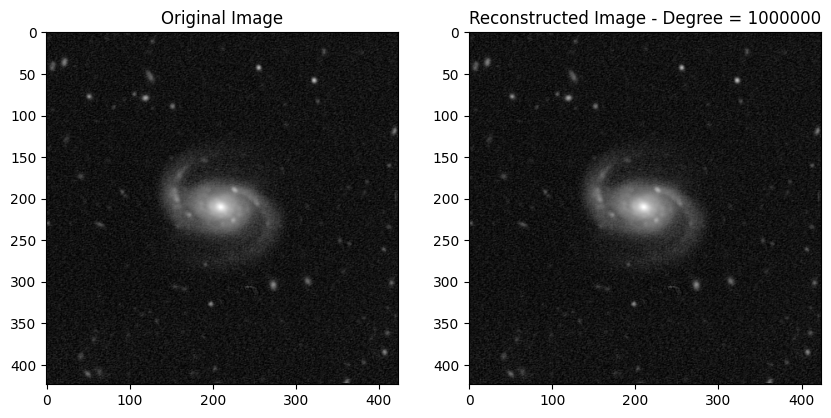

In [30]:
image_path = 'galaxies/spiral_arms/newJ235628.39-005038.0.png'
image = io.imread(image_path, as_gray=True)

degree = 1000000  # adjust the polynomial degree as needed

reconstructed_image = reconstruct_image(image, degree)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f'Reconstructed Image - Degree = {degree}')
plt.show()

In [ ]:
def reconstructs_and_save(image_path, degree):
    image = io.imread(image_path, as_gray=True)
    reconstructed_image = np.concatenate([reconstruct_image(image, degree)[..., np.newaxis]] * 3, axis=-1)
    reconstructed_image = (reconstructed_image * 255/np.max(reconstructed_image)).astype(np.uint8)
    file_directory, extension = os.path.splitext(image_path)
    _, galaxy_type, galaxy_name = file_directory.split('/')
    if not os.path.exists('galaxies_reconstructed_d={}/'.format(degree) + galaxy_type): os.makedirs('galaxies_reconstructed_d={}/'.format(degree) + galaxy_type)
    output_filename = 'galaxies_reconstructed_d={}/'.format(degree) + galaxy_type + '/' + galaxy_name + extension
    plt.imsave(output_filename, reconstructed_image)

Reconstruct all images

In [ ]:
folder_name = 'galaxies'
degree = 100000  # Adjust as needed

for galaxy_type in os.listdir(folder_name):
    for galaxy_name in os.listdir(folder_name + '/' + galaxy_type):
        reconstructs_and_save(folder_name + '/' + galaxy_type + '/' + galaxy_name, degree)